<a href="https://colab.research.google.com/github/b4wolf/NEURALNETS/blob/development/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.impute import SimpleImputer

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Ignore everything above

In [195]:
pm10_df = pd.read_csv("/content/cleaned_MKE_2020_pm10.csv")
pm25_df = pd.read_csv("/content/split_0_8765.csv")
so2_df = pd.read_csv("/content/cleaned_MKE_2020_so2.csv")

pm25_df['Datetime'] = pd.to_datetime(pm25_df['Date Local'] + ' ' + pm25_df['Time Local'])
pm25_df = pm25_df[['Datetime', 'Sample Measurement']]
pm10_df['Datetime'] = pd.to_datetime(pm10_df['Date Local'] + ' ' + pm10_df['Time Local'])
pm10_df = pm10_df[['Datetime', 'Sample Measurement']]
so2_df['Datetime'] = pd.to_datetime(so2_df['Date Local'] + ' ' + so2_df['Time Local'])
so2_df = so2_df[['Datetime', 'Sample Measurement']]


imp = SimpleImputer(strategy="most_frequent")
def infill(df1):
  df = df1.set_index('Datetime')

  # Create complete hourly range
  full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
  return df.reindex(full_range)

pm10_df = infill(pm10_df)
imp.fit_transform(pm10_df)
pm25_df = infill(pm25_df)
imp.fit_transform(pm25_df)
so2_df = infill(so2_df)
imp.fit_transform(so2_df)


print(pm10_df.shape[0])
print(pm25_df.shape[0])
print(so2_df.shape[0])

8784
8784
8784


In [196]:
# from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
# Creates a series of lookback windows to be used for training and predicting window t+1
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [198]:

timeseries = pd.concat((pm25_df[['Sample Measurement']], pm10_df[['Sample Measurement']], so2_df[['Sample Measurement']]), axis=1).values.astype('float32')
train_size = int(len(timeseries) * 0.75)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
train.shape, test.shape

((6588, 3), (2196, 3))

2

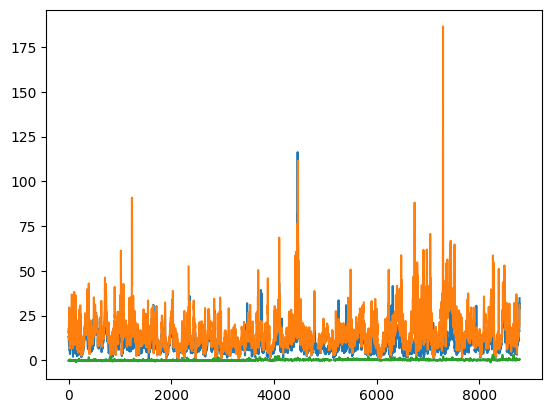

In [206]:
plt.plot(timeseries)

In [27]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([6567, 7, 1]) torch.Size([6567, 7, 1])
torch.Size([2185, 7, 1]) torch.Size([2185, 7, 1])


<ipython-input-25-441be4e99ef4>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


In [30]:
class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [31]:
import torch.optim as optim
import torch.utils.data as data

model = LSTM_Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
#plt.xlim(7250, 7750)
plt.show()